Раскидывание данных для первого водителя по массивам:

In [1]:
%matplotlib inline
import pandas
import math
import matplotlib.pyplot as plt
import re
import datetime
import sort_coordinates

data = pandas.read_csv('data1.tsv', sep="\t")
debug = pandas.read_csv('debug1.tsv', sep="\t")
#debug[debug["hash"] == 86]
# names=['date', 'id', 'type', 'hash', 'latitude', 'longitude']
id_unique = data["id"].unique()
date_points = []
lat_points = []
lon_points = []
format_date = "%Y-%m-%d %H:%M:%S"

for i in id_unique:
    str_date = data[data["id"] == i]["date"].copy()
    datepstr = []
    for s in str_date:
        t = datetime.datetime.strptime(s, format_date)
        datepstr.append(t)
    date_points.append(datepstr)
    lat = sort_coordinates.del_invalid_idx(data[data["id"] == i]["latitude"].copy())
    lat_points.append(lat)
    lon = sort_coordinates.del_invalid_idx(data[data["id"] == i]["longitude"].copy())
    lon_points.append(lon)

Время так же важно. Между 1 и 2 временем значительно меньше времени, чем между 2 и 3. 
Соответственно нужно посмотреть на сколько большой/маленький отрезок пройден за время между точками. А значит нужно всё таки знать скорость.

In [2]:
speed = []
for j in range(len(lat_points) - 1):
    speed_hero = []
    for i in range(len(lat_points[j]) - 1):
        range_way = math.sqrt(math.pow(lat_points[j][i+1] - lat_points[j][i], 2)
                              + math.pow(lon_points[j][i+1] - lon_points[j][i], 2))
        range_time = (date_points[j][i + 1] - date_points[j][i]).total_seconds()
        speed_hero.append(range_way/range_time)
    speed.append(speed_hero)


In [3]:
import sort_coordinates

sort_speed = []

idx = 0

sort_lat = []
sort_lon = []
for i in range(len(speed)-1):
    temp_lat_points = sort_coordinates.del_invalid_idx(lat_points[i])
    temp_lon_points = sort_coordinates.del_invalid_idx(lon_points[i])
    lat = []
    lon = []
    sp = []
    temp_speed_array = speed[i].copy()
    while len(temp_speed_array) != 0:
        min_speed = 100000
        for i in range(len(temp_speed_array)-1):
            if min_speed > temp_speed_array[i]:
                min_speed = temp_speed_array[i]
                idx = i
        sp.append((idx, temp_speed_array.pop(idx)))
        lat.append((temp_lat_points.pop(idx), temp_lat_points[idx]))
        lon.append((temp_lon_points.pop(idx), temp_lon_points[idx]))
    sort_lat.append(lat)
    sort_lon.append(lon)
    sort_speed.append(sp)



Как отсортировать скорость сохраняя индекс вторым параметром?

Нужно понять какая скорость максимальная для остановок, чтобы решить какое кол-во точек, где тормозит водитель брать. Плюс нельзя забывать о том, что их в любом случае должно быть значительно больше так как светафоры/пробки...

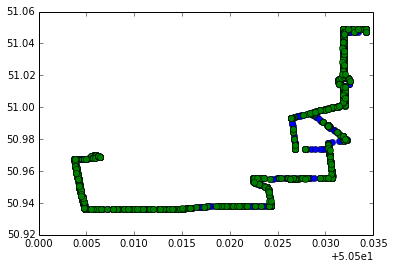

In [4]:
plt.plot(lat, lon, 'o')
plt.plot(debug["latitude"], debug["longitude"], 'o', c = 'g')

Нужно придумать как определять число остановок и предварительно разделить маршрут на 2 части - в одну и в другую сторону.

Можно основываясь на данных debug определить минимальную скорость для отрезка на котором находиться остановка.

Причём надо не индекс точки запоминать, а именно отрезки соединяющие эти точки.

Поиск первого круга:

In [5]:
f_lat_points = []
f_lon_points = []
s_lat_points = []
s_lon_points = []
ways_x = []
ways_y = []
f_point_x = [date_points[0][0], date_points[0][1], date_points[0][2]]
f_point_y = [date_points[0][0], date_points[0][1], date_points[0][2]]
b_lat_points = []
b_lon_points = []
range_time = 0
i = 0
while range_time < 5*60:
    i = i + 1
    range_time = (date_points[0][i] - date_points[0][0]).total_seconds()
max_eps = math.sqrt(math.pow(lat_points[0][i]- lat_points[0][0], 2)
                      + math.pow(lat_points[0][i] - lon_points[0][0], 2))
for j in range(len(lat_points[0]) - i - 4):
    way_f = math.sqrt(math.pow(lat_points[0][j+i+1]- lat_points[0][0], 2)
                      + math.pow(lat_points[0][j+i+1] - lon_points[0][0], 2))
    way_s = math.sqrt(math.pow(lat_points[0][j+i+2]- lat_points[0][0], 2)
                      + math.pow(lat_points[0][j+i+2] - lon_points[0][0], 2))
    way_t = math.sqrt(math.pow(lat_points[0][j+i+3]- lat_points[0][0], 2)
                      + math.pow(lat_points[0][j+i+3] - lon_points[0][0], 2))
    if way_f > max_eps and  way_s > max_eps  and  way_t > max_eps:
        idx_last_point = 0
        
        while (1):
            way_next = math.sqrt(math.pow(lat_points[0][j+i+3 + idx_last_point]- lat_points[0][0], 2)
                                 + math.pow(lat_points[0][j+i+3 + idx_last_point] - lon_points[0][0], 2))
            print(way_next , way_t)
            if (way_t < way_next):
                break
                
            idx_last_point = idx_last_point + 1
           
            
        ways_x= lat_points[0][:j+3+i + idx_last_point + 1]
        ways_y = lon_points[0][:j+3+i + idx_last_point + 1]
        break
    
         

0.46569322023087273 0.46569322023087273
0.46572034854512157 0.46569322023087273


Сравниваю расстояние между 3-мя стартовыми координатами и тремя следующими подраяд. Если max_eps > получаю конец круга.

1


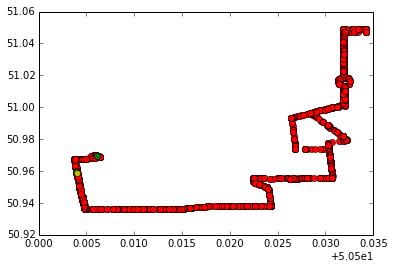

In [6]:
plt.plot(lat, lon, 'o', c = 'r')
print (i)

plt.plot(ways_x[len(ways_x)-2], ways_y[len(ways_x)-2], 'o', c = 'g')
plt.plot(ways_x[len(ways_x)-3], ways_y[len(ways_x)-3], 'o', c = 'y')
plt.plot(ways_x[0], ways_y[0], 'o', c = 'g')

Зелёная - это старт, желтая - это точка попадающая в "круг" из 15 минут.

Далее нужно найти максимально ближнюю точку и взоможно(100%) стоит сократить время "круга".

In [9]:
l = debug["latitude"].copy()
print(len (l))

47


In [10]:
l.pop(30)
print(l[30])

KeyError: 30